## Plotting Code

In [1]:
import shapely 
# function: plots one line (not a lineList) with first and last points with different colors
def plot_line(ax, line, color):
    #line = [(x, y),...]
    x, y = LineString(line).xy
    # plot lines between points
    ax.plot(x, y, color= color, alpha=0.7, linewidth=1, solid_capstyle='round', zorder=1)
    # Plot first and last points with different colors
#     ax.plot(x[0], y[0], 'o', color='#80F222', zorder=2)
#     ax.plot(x[-1], y[-1], 'o', color='#F22222', zorder=2)
    
# function: handle axes limits and title of a plot of a (lineList 
def handle_axesLimTitle_for_lineList(ax, lineList, title):
    #lineList = [line1, ...]
    allXList = []
    allYList = []
    for line in lineList:
        for point in line:
            allXList.append(point[0])
            allYList.append(point[1])
    XLim = [min(allXList), max(allXList)]
    YLim = [min(allYList), max(allYList)]
    XEmptySpace = int((XLim[1]-XLim[0])/5.0)
    YEmptySpace = int((YLim[1]-YLim[0])/5.0)
    if XEmptySpace == 0:
        XEmptySpace = 1
    if YEmptySpace == 0:
        YEmptySpace = 1
    Xrange = [int(XLim[0]) - XEmptySpace, int(XLim[1]) + XEmptySpace]
    Yrange = [int(YLim[0]) - YEmptySpace, int(YLim[1]) + YEmptySpace]
    ax.set_xlim(*Xrange)
    ax.set_ylim(*Yrange)
    # ax.set_yticks(list(range(*Yrange)) + [Yrange[-1]])
    # ax.set_aspect(1)
    ax.set_title(title) 

In [2]:
import shapely
import matplotlib
from shapely.geometry import Point
from shapely.geometry import LineString
from matplotlib import pyplot
import mpld3
%matplotlib inline
mpld3.enable_notebook()
from copy import deepcopy

## Function:
* input list of lines
* list of cleaned version

In [126]:
def lenLine(line):
    return Point(line[0]).distance(Point(line[1]))

def cosAndsine(line):
    # cos and sine made with horizon
    if lenLine(line) != 0:
        cos = float(line[1][0] - line[0][0])/float(lenLine(line))
        sine = float(line[1][1] - line[0][1])/float(lenLine(line))
        return [cos, sine]
    else:
        
        print "Warning: Following Line is changed to a Point Maybe Check your tolerances"
        print line
        return [0,0]
    
def connectToAvgIfCloseEnough(twoLineList, tolClose):
    lineAfterList = deepcopy(twoLineList)
    for i in range(len(twoLineList[0])):
        for j in range(len(twoLineList[1])):
            if Point(twoLineList[0][i]).distance(Point(twoLineList[1][j])) < tolClose:
                avgX = (twoLineList[0][i][0] + twoLineList[1][j][0])/float(2)
                avgY = (twoLineList[0][i][1] + twoLineList[1][j][1])/float(2)
                lineAfterList[0][i] = (avgX, avgY)
                lineAfterList[1][j] = (avgX, avgY)
    return lineAfterList

def cleanIfintesectedAlready(twoLineList, tolInt, tolClose):
    lines = deepcopy(twoLineList)
    intrsct = LineString(lines[0]).intersection(LineString(lines[1]))
    if intrsct.length == 0:
        for i in range(len(lines)):
            for j in range(2):
                if Point(lines[i][-j]).distance(intrsct) < tolInt:
                    lines[i][-j] = (intrsct.x, intrsct.y)
        return lines
    else: 
        return connectToAvgIfCloseEnough(lines, tolClose)

def givefirstandLasttwoLines(line):
    return [ [line[0],line[1]], [line[-2], line[-1]] ]
    
    
def extendMultiSectioLinefromBothsides(line, extL):
    extLine = deepcopy(line)
    if len(line) > 2:
        firstLast = givefirstandLasttwoLines(line)
        for j in range(len(firstLast)):
            line = firstLast[j]
            cosT = cosAndsine(line)[0]
            sinT = cosAndsine(line)[1]
            extCoordsPos = (line[-j][0] + extL * cosT, line[-j][1] + extL * sinT)
            extCoordsNeg = (line[-j][0] - extL * cosT, line[-j][1] - extL * sinT)
            if Point(extCoordsPos).distance(Point(extLine[1-3*j])) > Point(extCoordsNeg).distance(Point(extLine[1-3*j])):
                extCoords = extCoordsPos
            else:
                extCoords = extCoordsNeg
            extLine[-j] = extCoords
        return extLine
    else:
        cosT = cosAndsine(line)[0]
        sinT = cosAndsine(line)[1]
        for j in range(len(line)):
            extCoordsPos = (line[-j][0] + extL * cosT, line[-j][1] + extL * sinT)
            extCoordsNeg = (line[-j][0] - extL * cosT, line[-j][1] - extL * sinT)
            if Point(extCoordsPos).distance(Point(extLine[abs(j-1)])) > Point(extCoordsNeg).distance(Point(extLine[abs(j-1)])):
                extCoords = extCoordsPos
            else:
                extCoords = extCoordsNeg
            extLine[j] = extCoords
        return extLine

def connectIfintesectedAfterExtending(twoLineList, extL ,tolInt,tolClose):
    lines = deepcopy(twoLineList)
    extLine1 = extendMultiSectioLinefromBothsides(twoLineList[0], extL)
    extLine2 = extendMultiSectioLinefromBothsides(twoLineList[1], extL)
    intrsct = LineString(extLine1).intersection(LineString(extLine2))
    if intrsct.length == 0:
        numDistanceBelowtolInt = 0
        for line in lines:
            for point in line:
                if Point(point).distance(intrsct) < tolInt:
                    numDistanceBelowtolInt += 1
        if numDistanceBelowtolInt > 1:
            for i in range(len(lines)):
                for j in range(2):
                    if Point(lines[i][-j]).distance(intrsct) < tolInt:
                        lines[i][-j] = (intrsct.x, intrsct.y)
            return lines
        else:
            return connectToAvgIfCloseEnough(lines, tolClose)
    else:
        return connectToAvgIfCloseEnough(lines, tolClose)

def cleanDanglesofAnyKind(twoLineList, extL, tolInt, tolClose):
    extline1 = extendMultiSectioLinefromBothsides(twoLineList[0], extL)
    extline2 = extendMultiSectioLinefromBothsides(twoLineList[1], extL)
    
    if LineString(twoLineList[0]).intersects(LineString(twoLineList[1])) == True:
        return cleanIfintesectedAlready(twoLineList, tolInt, tolClose)
    
    elif LineString(extline1).intersects(LineString(extline2)) == True:
        return connectIfintesectedAfterExtending(twoLineList, extL ,tolInt, tolClose)
    
    else:
        return connectToAvgIfCloseEnough(twoLineList, tolClose)
def cleanEachGroup(linesList, extL, tolInt, tolClose):
    linesListClean = deepcopy(linesList)
    for i in range(len(linesListClean)):
        for j in range(i+1, len(linesListClean)):
            twoline = [linesListClean[i], linesListClean[j]]
            twolineclean = cleanDanglesofAnyKind(twoline, extL, tolInt, tolClose)
            if twoline[0] != twolineclean[0]:
                linesListClean[i] = twolineclean[0]
            if twoline[1] != twolineclean[1]:
                linesListClean[j] = twolineclean[1]
    return linesListClean

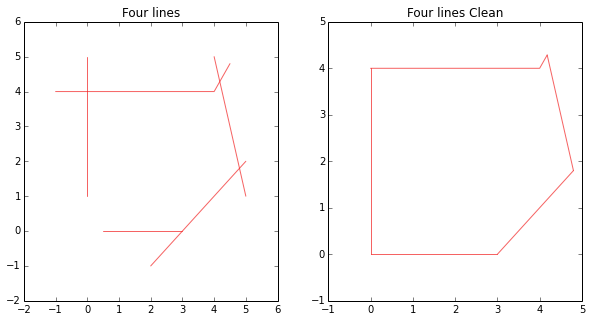

In [127]:
A, B = (0,1), (0,5)
line1 = [A, B]
A, B = (-1,4), (4,4)
line2 = [A, B,(4.5, 4.8)]
A, B = (5,2), (2,-1)
line3 = [A, B]
A, B = (0.5,0), (3,0)
line4 = [A, B]
line5 =[(4,5), (5,1)]

fourLineList = [line1, line2, line3, line4, line5]
extL, tolInt, tolClose = 100, 1.5, 0.5
fourLineListClean = cleanEachGroup(fourLineList, extL, tolInt, tolClose)
fig = pyplot.figure(1, figsize=(10,5), dpi=90)
ax = fig.add_subplot(121)
for line in fourLineList:
    plot_line(ax, line, '#F22222')
handle_axesLimTitle_for_lineList(ax, fourLineList, "Four lines")
ax = fig.add_subplot(122)
for line in fourLineListClean:
    plot_line(ax, line, '#F22222')
handle_axesLimTitle_for_lineList(ax, fourLineListClean, "Four lines Clean")

## Code:

In [ ]:
import shapely
import matplotlib
from shapely.geometry import Point
from shapely.geometry import LineString
from matplotlib import pyplot
import mpld3
%matplotlib inline
mpld3.enable_notebook()
from copy import deepcopy

def lenLine(line):
    return Point(line[0]).distance(Point(line[1]))

def cosAndsine(line):
    # cos and sine made with horizon
    if lenLine(line) != 0:
        cos = float(line[1][0] - line[0][0])/float(lenLine(line))
        sine = float(line[1][1] - line[0][1])/float(lenLine(line))
        return [cos, sine]
    else:
        
        print "Warning: Following Line is changed to a Point Maybe Check your tolerances"
        print line
        return [0,0]
    
def connectToAvgIfCloseEnough(twoLineList, tolClose):
    lineAfterList = deepcopy(twoLineList)
    for i in range(len(twoLineList[0])):
        for j in range(len(twoLineList[1])):
            if Point(twoLineList[0][i]).distance(Point(twoLineList[1][j])) < tolClose:
                avgX = (twoLineList[0][i][0] + twoLineList[1][j][0])/float(2)
                avgY = (twoLineList[0][i][1] + twoLineList[1][j][1])/float(2)
                lineAfterList[0][i] = (avgX, avgY)
                lineAfterList[1][j] = (avgX, avgY)
    return lineAfterList

def cleanIfintesectedAlready(twoLineList, tolInt, tolClose):
    lines = deepcopy(twoLineList)
    intrsct = LineString(lines[0]).intersection(LineString(lines[1]))
    if intrsct.length == 0:
        for i in range(len(lines)):
            for j in range(2):
                if Point(lines[i][-j]).distance(intrsct) < tolInt:
                    lines[i][-j] = (intrsct.x, intrsct.y)
        return lines
    else: 
        return connectToAvgIfCloseEnough(lines, tolClose)

def givefirstandLasttwoLines(line):
    return [ [line[0],line[1]], [line[-2], line[-1]] ]
    
    
def extendMultiSectioLinefromBothsides(line, extL):
    extLine = deepcopy(line)
    if len(line) > 2:
        firstLast = givefirstandLasttwoLines(line)
        for j in range(len(firstLast)):
            line = firstLast[j]
            cosT = cosAndsine(line)[0]
            sinT = cosAndsine(line)[1]
            extCoordsPos = (line[-j][0] + extL * cosT, line[-j][1] + extL * sinT)
            extCoordsNeg = (line[-j][0] - extL * cosT, line[-j][1] - extL * sinT)
            if Point(extCoordsPos).distance(Point(extLine[1-3*j])) > Point(extCoordsNeg).distance(Point(extLine[1-3*j])):
                extCoords = extCoordsPos
            else:
                extCoords = extCoordsNeg
            extLine[-j] = extCoords
        return extLine
    else:
        cosT = cosAndsine(line)[0]
        sinT = cosAndsine(line)[1]
        for j in range(len(line)):
            extCoordsPos = (line[-j][0] + extL * cosT, line[-j][1] + extL * sinT)
            extCoordsNeg = (line[-j][0] - extL * cosT, line[-j][1] - extL * sinT)
            if Point(extCoordsPos).distance(Point(extLine[abs(j-1)])) > Point(extCoordsNeg).distance(Point(extLine[abs(j-1)])):
                extCoords = extCoordsPos
            else:
                extCoords = extCoordsNeg
            extLine[j] = extCoords
        return extLine

def connectIfintesectedAfterExtending(twoLineList, extL ,tolInt,tolClose):
    lines = deepcopy(twoLineList)
    extLine1 = extendMultiSectioLinefromBothsides(twoLineList[0], extL)
    extLine2 = extendMultiSectioLinefromBothsides(twoLineList[1], extL)
    intrsct = LineString(extLine1).intersection(LineString(extLine2))
    if intrsct.length == 0:
        numDistanceBelowtolInt = 0
        for line in lines:
            for point in line:
                if Point(point).distance(intrsct) < tolInt:
                    numDistanceBelowtolInt += 1
        if numDistanceBelowtolInt > 1:
            for i in range(len(lines)):
                for j in range(2):
                    if Point(lines[i][-j]).distance(intrsct) < tolInt:
                        lines[i][-j] = (intrsct.x, intrsct.y)
            return lines
        else:
            return connectToAvgIfCloseEnough(lines, tolClose)
    else:
        return connectToAvgIfCloseEnough(lines, tolClose)

def cleanDanglesofAnyKind(twoLineList, extL, tolInt, tolClose):
    extline1 = extendMultiSectioLinefromBothsides(twoLineList[0], extL)
    extline2 = extendMultiSectioLinefromBothsides(twoLineList[1], extL)
    
    if LineString(twoLineList[0]).intersects(LineString(twoLineList[1])) == True:
        return cleanIfintesectedAlready(twoLineList, tolInt, tolClose)
    
    elif LineString(extline1).intersects(LineString(extline2)) == True:
        return connectIfintesectedAfterExtending(twoLineList, extL ,tolInt, tolClose)
    
    else:
        return connectToAvgIfCloseEnough(twoLineList, tolClose)
def cleanEachGroup(linesList, extL, tolInt, tolClose):
    linesListClean = deepcopy(linesList)
    for i in range(len(linesListClean)):
        for j in range(i+1, len(linesListClean)):
            twoline = [linesListClean[i], linesListClean[j]]
            twolineclean = cleanDanglesofAnyKind(twoline, extL, tolInt, tolClose)
            if twoline[0] != twolineclean[0]:
                linesListClean[i] = twolineclean[0]
            if twoline[1] != twolineclean[1]:
                linesListClean[j] = twolineclean[1]
    return linesListClean

import shapely 
# function: plots one line (not a lineList) with first and last points with different colors
def plot_line(ax, line, color):
    #line = [(x, y),...]
    x, y = LineString(line).xy
    # plot lines between points
    ax.plot(x, y, color= color, alpha=0.7, linewidth=1, solid_capstyle='round', zorder=1)
    # Plot first and last points with different colors
#     ax.plot(x[0], y[0], 'o', color='#80F222', zorder=2)
#     ax.plot(x[-1], y[-1], 'o', color='#F22222', zorder=2)
    
# function: handle axes limits and title of a plot of a (lineList 
def handle_axesLimTitle_for_lineList(ax, lineList, title):
    #lineList = [line1, ...]
    allXList = []
    allYList = []
    for line in lineList:
        for point in line:
            allXList.append(point[0])
            allYList.append(point[1])
    XLim = [min(allXList), max(allXList)]
    YLim = [min(allYList), max(allYList)]
    XEmptySpace = int((XLim[1]-XLim[0])/5.0)
    YEmptySpace = int((YLim[1]-YLim[0])/5.0)
    if XEmptySpace == 0:
        XEmptySpace = 1
    if YEmptySpace == 0:
        YEmptySpace = 1
    Xrange = [int(XLim[0]) - XEmptySpace, int(XLim[1]) + XEmptySpace]
    Yrange = [int(YLim[0]) - YEmptySpace, int(YLim[1]) + YEmptySpace]
    ax.set_xlim(*Xrange)
    ax.set_ylim(*Yrange)
    # ax.set_yticks(list(range(*Yrange)) + [Yrange[-1]])
    # ax.set_aspect(1)
    ax.set_title(title) 